# Phase Diagrams

In this notebook we create a phase diagram spheres/non-spheres using a fitted probabilistic model. For that let us fit a random forest model on all available data.

In [1]:
import data1 as data
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(data.x, data.sphere)
rf.predict_proba(data.x)

array([[0.9 , 0.1 ],
       [0.12, 0.88],
       [0.33, 0.67],
       ...,
       [0.9 , 0.1 ],
       [0.97, 0.03],
       [0.96, 0.04]])

Now we select all data points that use the conditions we want to fix in the phase diagram and pick the first of those as 'prototype' to generate virtual data for plotting the probability surface of the model.

In [2]:
query = (data.x.core_HPMA == 1) & (data.x.corona_GMA == 1) & (data.x.dp_corona==78) & (data.x.salt==0) & (data.x.ph==7) & (data.x.charged==0) & (data.x.temp==70)

points = data.x[query]

prototype = points.iloc[0]
prototype

clogp_corona                0.090000
mon_corona_mw             160.070000
mon_corona_apol            23.529516
mon_corona_mv               1.243700
mon_corona_psa             66.760000
dp_corona                  78.000000
corona_mw_total         12485.460000
corona_mv_total            97.008600
clogp_core                  1.100000
mon_core_mw               144.080000
mon_core_apol              22.727516
mon_core_mv                 1.185000
mon_core_psa               46.530000
dp_core                   150.000000
core_mw_total           21612.000000
core_mv_total             177.750000
ratio_mass                  0.366170
ratio_vol                   0.353068
conc                       10.000000
ph                          7.000000
salt                        0.000000
charged                     0.000000
temp                       70.000000
core_BzMA                   0.000000
core_DAAM                   0.000000
core_EGEMA                  0.000000
core_GlyMA                  0.000000
c

Using the prototype we generate a new dataset where concentration and degree of core polymerisation is varied over a meshgrid.

Importantly, we have to take care of recomputing the derived variables that depend on the degree of core polymerisation.

In [5]:
import numpy as np
xx = np.linspace(6, 28, 200)
yy = np.linspace(120, 530, 200)
xx, yy = np.meshgrid(xx, yy, indexing='xy')

In [6]:
from pandas import DataFrame
from copy import deepcopy

df = DataFrame(columns=data.x.columns)
m, n = xx.shape
df = df.append([deepcopy(prototype) for _ in range(m*n)], ignore_index=True)
df['conc'] = xx.ravel()
df['dp_core'] = yy.ravel()
df['core_mw_total'] = df['dp_core']*df['mon_core_mw']
df['core_mv_total'] = df['dp_core']*df['mon_core_mv']

df.ratio_mass = df.corona_mw_total / (df.corona_mw_total + df.core_mw_total)
df.ratio_vol = df.corona_mv_total / (df.corona_mv_total + df.core_mv_total)

zz = rf.predict_proba(df)[:, 1].reshape(m, n)

Finally, we can create the contour plot of the modelled probalities along with our actual points that satisfy the conditions.

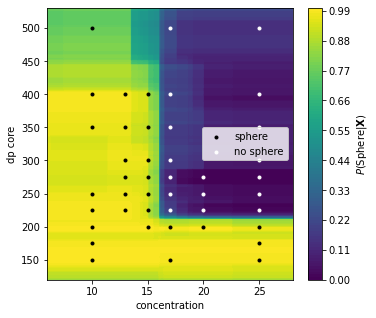

In [7]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(5.5,5))
cp = plt.contourf(xx, yy, zz, levels=100)
x = points['conc']
y = points['dp_core']
plt.scatter(x[data.sphere==1], y[data.sphere==1], marker='.', color='black', label='sphere')
plt.scatter(x[data.sphere!=1], y[data.sphere!=1], marker='.', color='white', label='no sphere')
plt.xlabel('concentration')
plt.ylabel('dp core')
plt.legend()
plt.colorbar(cp, label=r'$P(\mathrm{Sphere | \mathbf{X}})$')
plt.show()